# Model Comparison - Option 3
#### The objective is to compare different machine learning models and evaluate performance using confusion matrix and classification report
- For this comparison, we will handle null values as follows:
    - Substituting NaNs with mean values
    - Dropping RainToday and RainTomorrow column NaN values 
- We will use data for years 2011 to 2016 because data is consistent and equal data points are available for each year

In [124]:
import warnings
warnings.filterwarnings('ignore')

In [125]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Import Data from Postgre

In [126]:
# import data from AWS RDS Database
conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw where year >=2011 and year <= 2016',  conn)
df.head()

date location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
0  2011-01-01   Albury     23.2     35.8       0.0       9999.0    9999.0   
1  2011-01-02   Albury     20.1     31.1       0.6       9999.0    9999.0   
2  2011-01-03   Albury     13.6     29.4       0.0       9999.0    9999.0   
3  2011-01-04   Albury     13.9     29.2       0.0       9999.0    9999.0   
4  2011-01-05   Albury     16.0     28.9       0.0       9999.0    9999.0   

  windgustdir  windgustspeed winddir9am  ... pressure3pm  cloud9am  cloud3pm  \
0         ENE           26.0          S  ...      1009.2    9999.0    9999.0   
1           W           35.0         SW  ...      1009.5    9999.0    9999.0   
2         WNW           35.0        SSE  ...      1009.3    9999.0    9999.0   
3         SSE           24.0         SE  ...      1007.8    9999.0    9999.0   
4         SSE           31.0        ENE  ...      1004.3    9999.0    9999.0   

   temp9am  temp3pm  raintoday  raintomorrow  year  month  day  
0     26.8     32.8         No            No  2011      1    1  
1     25.1     30.2         No            No  2011      1    2  
2     20.2     28.4         No            No  2011      1    3  
3     19.9     27.9         No            No  2011      1    4  
4     22.0     26.8         No            No  2011      1    5  

[5 rows x 26 columns]

## Data Analysis

In [127]:
df.shape

(100935, 26)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100935 entries, 0 to 100934
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           100935 non-null  object 
 1   location       100935 non-null  object 
 2   mintemp        100935 non-null  float64
 3   maxtemp        100935 non-null  float64
 4   rainfall       100935 non-null  float64
 5   evaporation    100935 non-null  float64
 6   sunshine       100935 non-null  float64
 7   windgustdir    100935 non-null  object 
 8   windgustspeed  100935 non-null  float64
 9   winddir9am     100935 non-null  object 
 10  winddir3pm     100935 non-null  object 
 11  windspeed9am   100935 non-null  float64
 12  windspeed3pm   100935 non-null  float64
 13  humidity9am    100935 non-null  float64
 14  humidity3pm    100935 non-null  float64
 15  pressure9am    100935 non-null  float64
 16  pressure3pm    100935 non-null  float64
 17  cloud9am       100935 non-nul

In [129]:
df = df.replace('9999', np.nan)
df = df.replace(9999, np.nan)
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [130]:
print('raintoday unique value count:  \n', df['raintoday'].value_counts())
print('\nunique location count: ', df['location'].nunique())
print('\nraintomorrow: ' , df['raintomorrow'].unique())
print('\nwindgustdir: ' , df['windgustdir'].unique())
print('\nHumidity3pm: ' , df['humidity3pm'].unique())
print("\nMissing Values :: \n",df.isnull().any())

raintoday unique value count:  
 No     76427
Yes    21979
Name: raintoday, dtype: int64

unique location count:  49

raintomorrow:  ['No' 'Yes' nan]

windgustdir:  ['ENE' 'W' 'WNW' 'SSE' 'NNE' 'NE' 'WSW' 'E' 'N' 'SW' 'NW' 'S' 'SE' 'ESE'
 'SSW' 'NNW' nan]

Humidity3pm:  [ 29.  27.  28.  38.  31.  34.  42.  40.  41.  87.  84.  59.  90.  46.
  36.  43.  37.  30.  20.  32.  25.  16.  49.  50.  99.  95.  45.  55.
  94.  57.  85.  51.  67.  54.  56.  61.  47.  58.  63.  64.  52.  66.
  53.  39.  89.  74.  48.  65.  72.  75.  79.  68.  92.  69.  70.  80.
  73.  88.  81.  76.  44.  83.  91.  71.  nan  33.  93.  35.  60.  78.
  62.  22.  21.  23.  19.  26.  18.  24.  86.  15. 100.  96.  97.  82.
  77.  17.  12.  11.  13.  98.  14.  10.   9.   7.   8.   6.   3.   5.
   1.   4.   2.   0.]

Missing Values :: 
 date             False
location         False
mintemp           True
maxtemp           True
rainfall          True
evaporation       True
sunshine          True
windgustdir       True
windg

## Handle Null Values

In [131]:
df = df.dropna(axis=0, subset=['raintomorrow'])
df = df.dropna(axis=0, subset=['raintoday'])

# Hanlde Nan in numeric columns
num_cols = df.select_dtypes('float64').columns.to_list()
print('\n float columns: ', num_cols)

for col in num_cols:
    df[col].fillna(df[col].mean(),inplace=True)
    
# Hanlde Nan in object columns
obj_cols = df.select_dtypes('object').columns.to_list()
print('\n object columns: ', obj_cols)

for col in obj_cols:
    df[col].fillna(df[col].mode(),inplace=True)    

df = df.reset_index(drop=True)

df.head()


 float columns:  ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm']

 object columns:  ['date', 'location', 'windgustdir', 'winddir9am', 'winddir3pm', 'raintoday', 'raintomorrow']


date location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
0  2011-01-01   Albury     23.2     35.8       0.0     5.561506  7.638637   
1  2011-01-02   Albury     20.1     31.1       0.6     5.561506  7.638637   
2  2011-01-03   Albury     13.6     29.4       0.0     5.561506  7.638637   
3  2011-01-04   Albury     13.9     29.2       0.0     5.561506  7.638637   
4  2011-01-05   Albury     16.0     28.9       0.0     5.561506  7.638637   

  windgustdir  windgustspeed winddir9am  ... pressure3pm  cloud9am  cloud3pm  \
0         ENE           26.0          S  ...      1009.2  4.443195  4.506955   
1           W           35.0         SW  ...      1009.5  4.443195  4.506955   
2         WNW           35.0        SSE  ...      1009.3  4.443195  4.506955   
3         SSE           24.0         SE  ...      1007.8  4.443195  4.506955   
4         SSE           31.0        ENE  ...      1004.3  4.443195  4.506955   

   temp9am  temp3pm  raintoday  raintomorrow  year  month  day  
0     26.8     32.8         No            No  2011      1    1  
1     25.1     30.2         No            No  2011      1    2  
2     20.2     28.4         No            No  2011      1    3  
3     19.9     27.9         No            No  2011      1    4  
4     22.0     26.8         No            No  2011      1    5  

[5 rows x 26 columns]

In [132]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Rainy Days' ,color ='raintoday')

In [133]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Expected Rainy Days' ,color ='raintomorrow')

In [134]:
print('unique location count: ', df['location'].nunique())

unique location count:  49


## Update "RainTomorrow" and "RainToday" Columns to Binary Values

In [135]:
df['raintomorrow'].value_counts()

No     75959
Yes    21464
Name: raintomorrow, dtype: int64

In [136]:
df['raintoday'].value_counts()

No     75758
Yes    21665
Name: raintoday, dtype: int64

In [137]:
df['raintomorrow'] = df.raintomorrow.eq('Yes').mul(1)
df['raintomorrow'] = df['raintomorrow'].astype(int)
df['raintomorrow'].value_counts()

0    75959
1    21464
Name: raintomorrow, dtype: int64

In [138]:
df['raintoday'] = df.raintoday.eq('Yes').mul(1)
df['raintoday'] = df['raintoday'].astype(int)
df['raintoday'].value_counts()

0    75758
1    21665
Name: raintoday, dtype: int64

In [139]:
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday          int32
raintomorrow       int32
year               int64
month              int64
day                int64
dtype: object

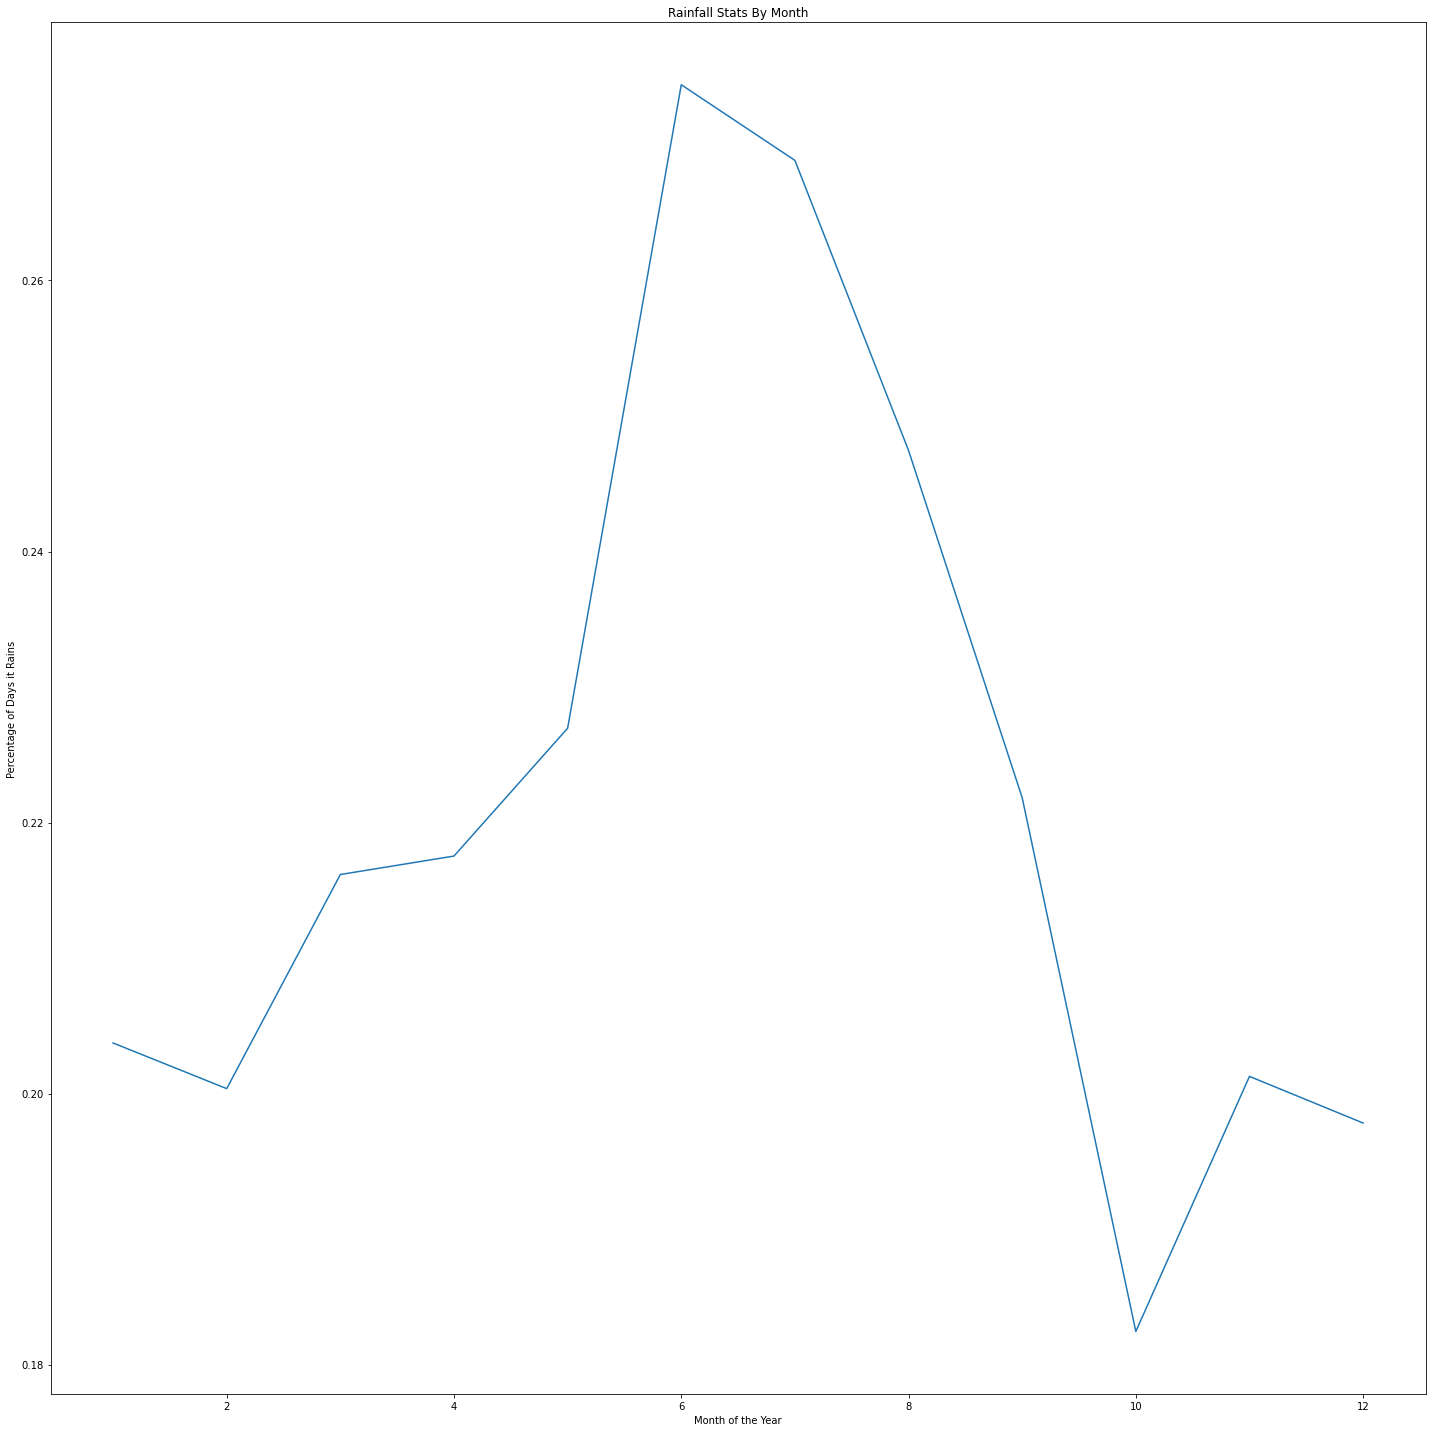

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

df_grouped = df.groupby('month').mean()
df_grouped[['raintoday']]
sns.lineplot(data=df_grouped, x=df_grouped.index, y='raintoday')

plt.title('Rainfall Stats By Month')
plt.xlabel('Month of the Year')
plt.ylabel('Percentage of Days it Rains')
plt.tight_layout();

## Drop Columns Unnecessary for Machine Learning Model
- Date column is not needed for model train as it has been split into Year, Month and Date
- Location will be dropped based on low correlation results from seaborn heatmap and model's feature importance

In [141]:
columns =  ['date', 'location'] 
df = df.drop(columns, axis=1)


In [142]:
print(df.shape)
df.head()

(97423, 24)


mintemp  maxtemp  rainfall  evaporation  sunshine windgustdir  \
0     23.2     35.8       0.0     5.561506  7.638637         ENE   
1     20.1     31.1       0.6     5.561506  7.638637           W   
2     13.6     29.4       0.0     5.561506  7.638637         WNW   
3     13.9     29.2       0.0     5.561506  7.638637         SSE   
4     16.0     28.9       0.0     5.561506  7.638637         SSE   

   windgustspeed winddir9am winddir3pm  windspeed9am  ...  pressure3pm  \
0           26.0          S        WSW          13.0  ...       1009.2   
1           35.0         SW        WSW           2.0  ...       1009.5   
2           35.0        SSE        WNW          19.0  ...       1009.3   
3           24.0         SE         SE          11.0  ...       1007.8   
4           31.0        ENE         SW           4.0  ...       1004.3   

   cloud9am  cloud3pm  temp9am  temp3pm  raintoday  raintomorrow  year  month  \
0  4.443195  4.506955     26.8     32.8          0             0  2011      1   
1  4.443195  4.506955     25.1     30.2          0             0  2011      1   
2  4.443195  4.506955     20.2     28.4          0             0  2011      1   
3  4.443195  4.506955     19.9     27.9          0             0  2011      1   
4  4.443195  4.506955     22.0     26.8          0             0  2011      1   

   day  
0    1  
1    2  
2    3  
3    4  
4    5  

[5 rows x 24 columns]

## Encode Columns Using OneHotEncoder

In [143]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['windgustdir', 'winddir9am', 'winddir3pm']

In [144]:
df[df_cat].nunique()

windgustdir    16
winddir9am     16
winddir3pm     16
dtype: int64

In [145]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(df_cat)
encode_df.head()


windgustdir_E  windgustdir_ENE  windgustdir_ESE  windgustdir_N  \
0            0.0              1.0              0.0            0.0   
1            0.0              0.0              0.0            0.0   
2            0.0              0.0              0.0            0.0   
3            0.0              0.0              0.0            0.0   
4            0.0              0.0              0.0            0.0   

   windgustdir_NE  windgustdir_NNE  windgustdir_NNW  windgustdir_NW  \
0             0.0              0.0              0.0             0.0   
1             0.0              0.0              0.0             0.0   
2             0.0              0.0              0.0             0.0   
3             0.0              0.0              0.0             0.0   
4             0.0              0.0              0.0             0.0   

   windgustdir_S  windgustdir_SE  ...  winddir3pm_NW  winddir3pm_S  \
0            0.0             0.0  ...            0.0           0.0   
1            0.0             0.0  ...            0.0           0.0   
2            0.0             0.0  ...            0.0           0.0   
3            0.0             0.0  ...            0.0           0.0   
4            0.0             0.0  ...            0.0           0.0   

   winddir3pm_SE  winddir3pm_SSE  winddir3pm_SSW  winddir3pm_SW  winddir3pm_W  \
0            0.0             0.0             0.0            0.0           0.0   
1            0.0             0.0             0.0            0.0           0.0   
2            0.0             0.0             0.0            0.0           0.0   
3            1.0             0.0             0.0            0.0           0.0   
4            0.0             0.0             0.0            1.0           0.0   

   winddir3pm_WNW  winddir3pm_WSW  winddir3pm_nan  
0             0.0             1.0             0.0  
1             0.0             1.0             0.0  
2             1.0             0.0             0.0  
3             0.0             0.0             0.0  
4             0.0             0.0             0.0  

[5 rows x 51 columns]

In [146]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_cat, axis=1)
df.head()

mintemp  maxtemp  rainfall  evaporation  sunshine  windgustspeed  \
0     23.2     35.8       0.0     5.561506  7.638637           26.0   
1     20.1     31.1       0.6     5.561506  7.638637           35.0   
2     13.6     29.4       0.0     5.561506  7.638637           35.0   
3     13.9     29.2       0.0     5.561506  7.638637           24.0   
4     16.0     28.9       0.0     5.561506  7.638637           31.0   

   windspeed9am  windspeed3pm  humidity9am  humidity3pm  ...  winddir3pm_NW  \
0          13.0           9.0         46.0         29.0  ...            0.0   
1           2.0          15.0         45.0         27.0  ...            0.0   
2          19.0          11.0         56.0         28.0  ...            0.0   
3          11.0          11.0         53.0         38.0  ...            0.0   
4           4.0           9.0         57.0         31.0  ...            0.0   

   winddir3pm_S  winddir3pm_SE  winddir3pm_SSE  winddir3pm_SSW  winddir3pm_SW  \
0           0.0            0.0             0.0             0.0            0.0   
1           0.0            0.0             0.0             0.0            0.0   
2           0.0            0.0             0.0             0.0            0.0   
3           0.0            1.0             0.0             0.0            0.0   
4           0.0            0.0             0.0             0.0            1.0   

   winddir3pm_W  winddir3pm_WNW  winddir3pm_WSW  winddir3pm_nan  
0           0.0             0.0             1.0             0.0  
1           0.0             0.0             1.0             0.0  
2           0.0             1.0             0.0             0.0  
3           0.0             0.0             0.0             0.0  
4           0.0             0.0             0.0             0.0  

[5 rows x 72 columns]

In [147]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am',
       'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm',
       'temp9am', 'temp3pm', 'raintoday', 'raintomorrow', 'year', 'month',
       'day', 'windgustdir_E', 'windgustdir_ENE', 'windgustdir_ESE',
       'windgustdir_N', 'windgustdir_NE', 'windgustdir_NNE', 'windgustdir_NNW',
       'windgustdir_NW', 'windgustdir_S', 'windgustdir_SE', 'windgustdir_SSE',
       'windgustdir_SSW', 'windgustdir_SW', 'windgustdir_W', 'windgustdir_WNW',
       'windgustdir_WSW', 'windgustdir_nan', 'winddir9am_E', 'winddir9am_ENE',
       'winddir9am_ESE', 'winddir9am_N', 'winddir9am_NE', 'winddir9am_NNE',
       'winddir9am_NNW', 'winddir9am_NW', 'winddir9am_S', 'winddir9am_SE',
       'winddir9am_SSE', 'winddir9am_SSW', 'winddir9am_SW', 'winddir9am_W',
       'winddir9am_WNW', 'winddir9am_WSW', 'winddir9am_nan', 'winddir3pm_E',
       'winddir3pm_

## Variable Declaration and Split into Test/Train

In [148]:
# define Target Variable
X = df.copy()
X = X.drop("raintomorrow", axis=1)
y = df["raintomorrow"]

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.8)
print(len(X_train))
print(len(X_test))

77938
19485


## Scale the Data
#### We will use standard scaler for the model

In [149]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Handle Class Imbalance

#### We decided to use Random Oversampling method because of the following reasons:
- SMOTE can be heavily influenced by outliers. 
- Undersampling causes loss of data and even though the dataset reasonably sized, we did not feel comfortable using undersampling
- Random Oversampling produced the highest precision score compared to SMOTE and SMOTEENN

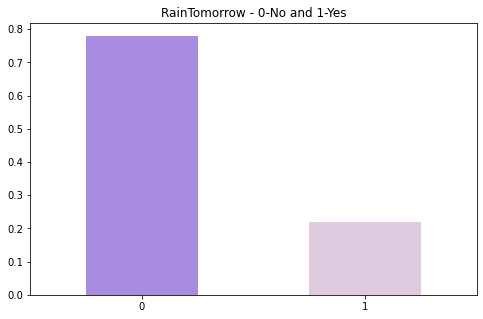

In [150]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
df.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['mediumpurple','thistle'], alpha = 0.8, rot=0)
plt.title('RainTomorrow - 0-No and 1-Yes')
plt.show()

In [151]:
# Resample the training data with the RandomOversampler
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


Counter(y_resampled)

Counter({0: 60767, 1: 60767})

##  Model Comparison:

#### For our model validation, we think precision is more important to predict rainfall (as opposed to sensitivity) in order to accurately plan for droughts. We will use the following for performance evaluation:

- Confusion Matrix
- Classification Report
- Accuracy Score

## 1) Random Forest

In [152]:
# Create a random forest classifier.

from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=128, random_state=42) 

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Making predictions using the testing data.
y_pred_rf = rf_model.predict(X_test_scaled)

# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf))

# Calculated the balanced accuracy score
print('Accuracy Score : ', balanced_accuracy_score(y_test, y_pred_rf))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.93      0.58      0.91      0.74      0.56     15192
          1       0.71      0.58      0.93      0.64      0.74      0.53      4293

avg / total       0.85      0.86      0.66      0.85      0.74      0.56     19485

Accuracy Score :  0.7587584025797535
Mean Absolute Error: 0.1430844239158327
Mean Squared Error: 0.1430844239158327
Root Mean Squared Error: 0.3782650180968797


In [153]:
# Calculating the confusion matrix.
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a DataFrame from the confusion matrix.
cm_df_rf = pd.DataFrame(cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df_rf

Predicted 0  Predicted 1
Actual 0        14193          999
Actual 1         1789         2504

#### Feature Importance

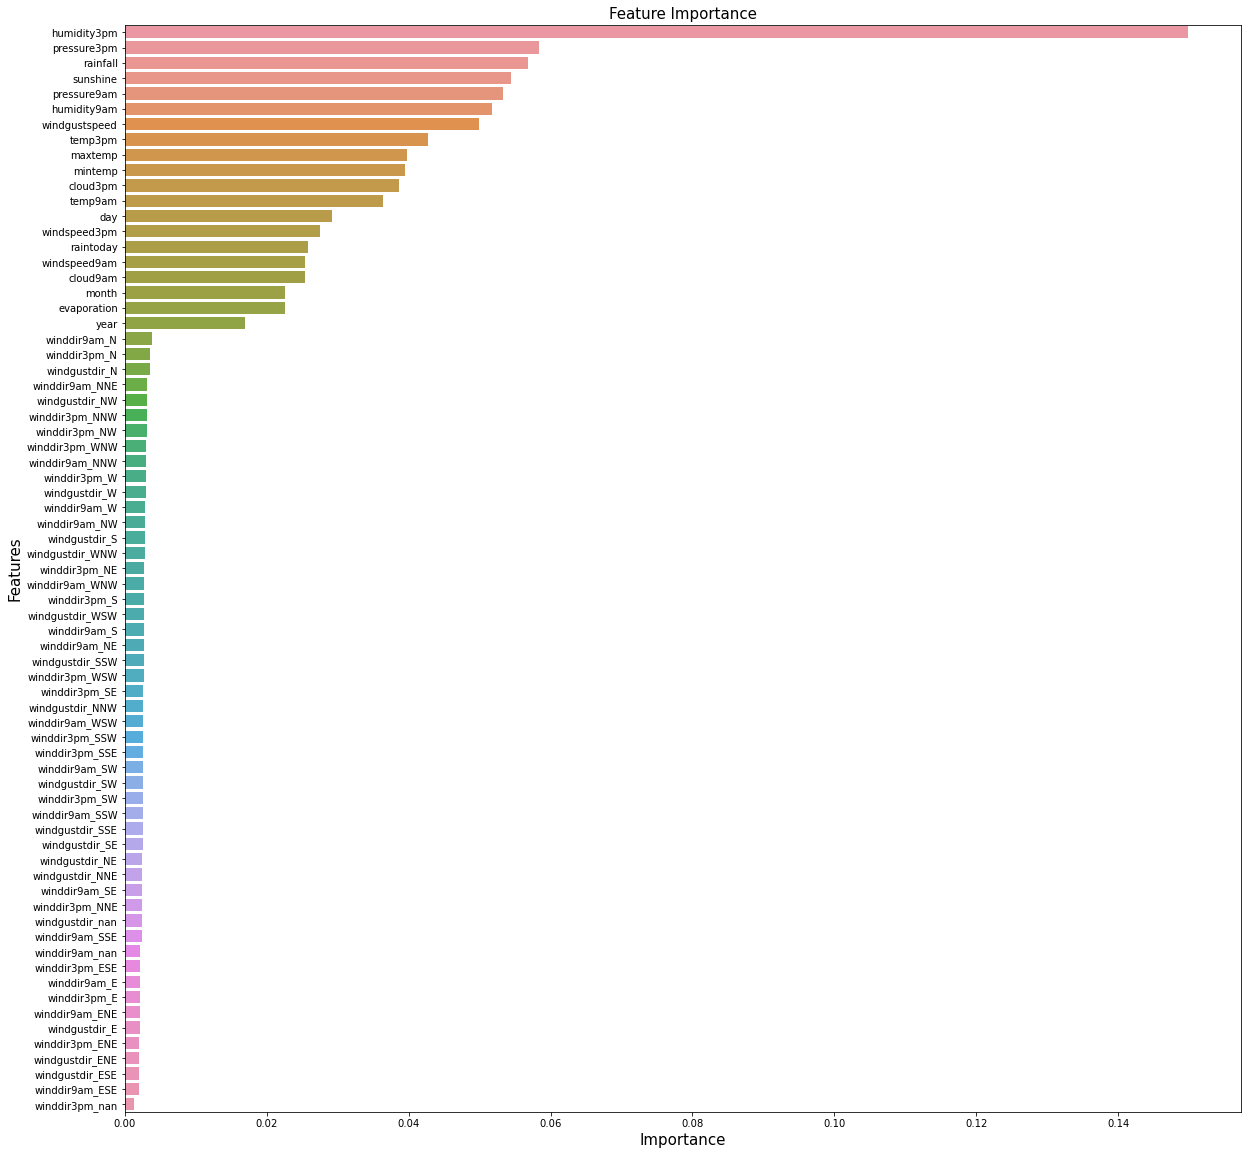

In [154]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_

#for importance, feat in sorted(zip(rf_model.feature_importances_, X.columns), reverse=True):
#    print(f'{feat}: ({importance})')

import matplotlib.pyplot as plt

important_features = pd.DataFrame({'Features': X.columns, 
                                   'Importance': rf_model.feature_importances_})

# print the dataframe
important_features.sort_values(by='Importance', ascending=False, inplace=True)

plt.rcParams['figure.figsize'] = 20,20
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## 2) Gradient Boosting

In [155]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

gb_model.fit(X_resampled, y_resampled)

y_pred_gb=gb_model.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred_gb))
print('Accuracy Score : ',balanced_accuracy_score(y_test, y_pred_gb))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.80      0.78      0.86      0.79      0.62     15192
          1       0.52      0.78      0.80      0.62      0.79      0.62      4293

avg / total       0.84      0.79      0.78      0.81      0.79      0.62     19485

Accuracy Score :  0.7884767498727676
Mean Absolute Error: 0.20579933282011803
Mean Squared Error: 0.20579933282011803
Root Mean Squared Error: 0.4536511135444484


In [156]:
# Calculating the confusion matrix.
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Create a DataFrame from the confusion matrix.
cm_df_gb = pd.DataFrame(cm_gb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
 
cm_df_gb

Predicted 0  Predicted 1
Actual 0        12134         3058
Actual 1          952         3341

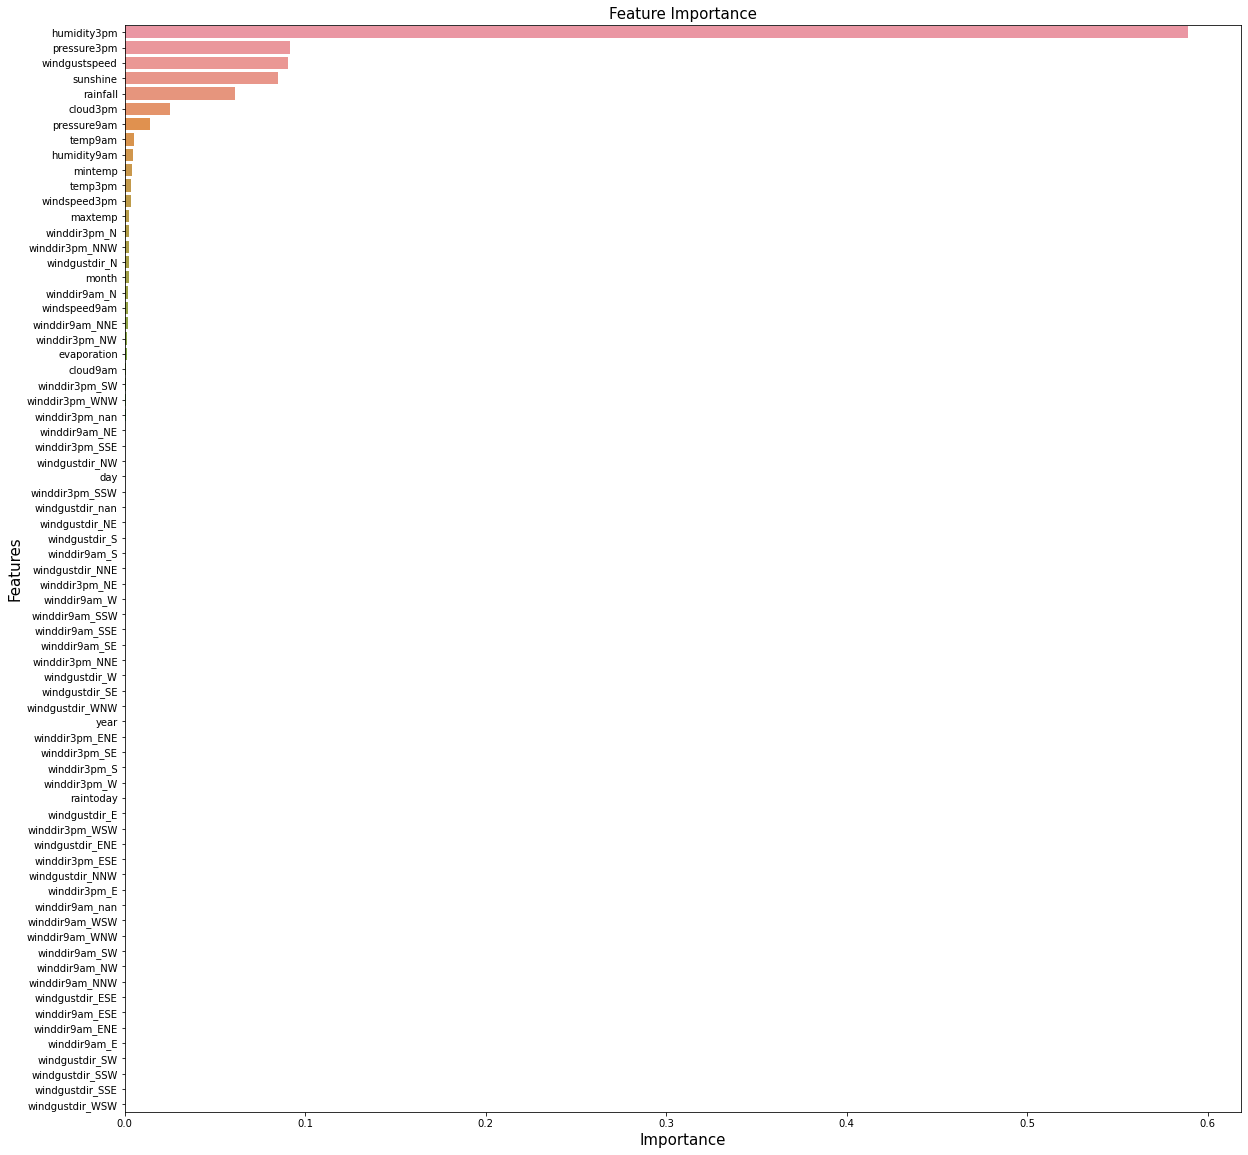

In [157]:
# List the features sorted in descending order by feature importance
import matplotlib.pyplot as plt

important_features_gb = pd.DataFrame({'Features': X.columns, 
                                   'Importance': gb_model.feature_importances_})

# print the dataframe
important_features_gb.sort_values(by='Importance', ascending=False, inplace=True)

plt.rcParams['figure.figsize'] = 20,20
sns.barplot(x = 'Importance', y = 'Features', data = important_features_gb)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## 3) Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_resampled,y_resampled)

y_pred_lr = lr_model.predict(X_test_scaled)

print(classification_report_imbalanced(y_test, y_pred_lr))
print('Accuracy Score : ',balanced_accuracy_score(y_test, y_pred_lr))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.80      0.77      0.86      0.78      0.62     15192
          1       0.52      0.77      0.80      0.62      0.78      0.61      4293

avg / total       0.83      0.79      0.78      0.80      0.78      0.61     19485

Accuracy Score :  0.7834307171489352
Mean Absolute Error: 0.2092378752886836
Mean Squared Error: 0.2092378752886836
Root Mean Squared Error: 0.45742526743576767


In [159]:
# Calculating the confusion matrix.
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Create a DataFrame from the confusion matrix.
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
 
cm_df_lr

Predicted 0  Predicted 1
Actual 0        12101         3091
Actual 1          986         3307

In [160]:
# List the features sorted in descending order by feature importance


## Model Comparison

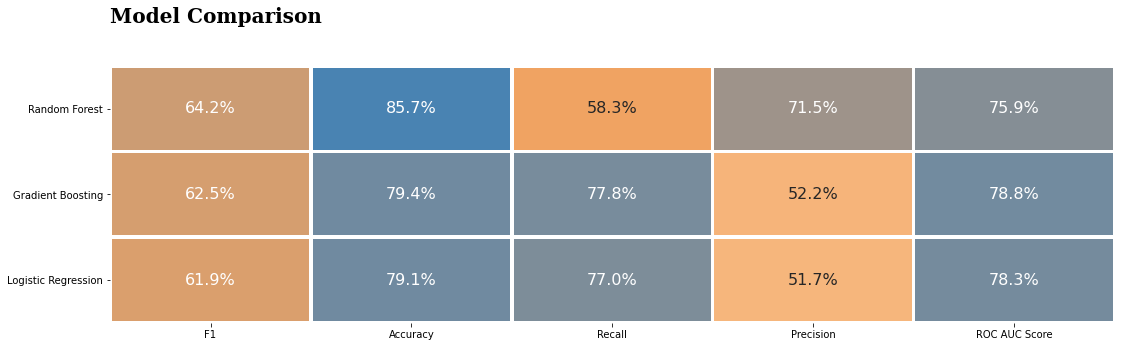

In [162]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib

rf_df = pd.DataFrame(data=[f1_score(y_test,y_pred_rf)
                            , accuracy_score(y_test, y_pred_rf)
                            , recall_score(y_test, y_pred_rf)
                            , precision_score(y_test, y_pred_rf)
                            , roc_auc_score(y_test, y_pred_rf)], 
                      columns=['Random Forest'], 
                      index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])


gb_df = pd.DataFrame(data=[f1_score(y_test,y_pred_gb)
                            , accuracy_score(y_test, y_pred_gb)
                            , recall_score(y_test, y_pred_gb)
                            , precision_score(y_test, y_pred_gb)
                            , roc_auc_score(y_test, y_pred_gb)], 
                      columns=['Gradient Boosting'], 
                      index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,y_pred_lr)
                            , accuracy_score(y_test, y_pred_lr)
                            , recall_score(y_test, y_pred_lr)
                            , precision_score(y_test, y_pred_lr)
                            , roc_auc_score(y_test, y_pred_lr)], 
                      columns=['Logistic Regression'], 
                      index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])


df_models = round(pd.concat([rf_df, gb_df, lr_df], axis=1),3)
colors = ["bisque","ivory","sandybrown","steelblue","lightsalmon"]
# ["bisque","ivory","sandybrown","steelblue","lightsalmon"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "white"

fig = plt.figure(figsize=(18,26)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=1.15, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":16})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Model Comparison',fontsize=20,fontweight='bold',fontfamily='serif')
plt.show()